In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("proteun4", "AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS")
]

In [2]:
print(alphabet)


In [3]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [4]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [5]:
token_representations[0].shape

torch.Size([288, 1280])

In [6]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    print(token_representations[i].shape)

torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])


## Attention representation

We may have more information if we can do the regression from the attention matrix.
The issue is that the size of the attention matrix depends on the length of the sequence. It could be that we could use the entire length that has zeros but then the regression model may get biased toward that.

How to go for a varying length attention representation to a regression??

torch.Size([286, 286])


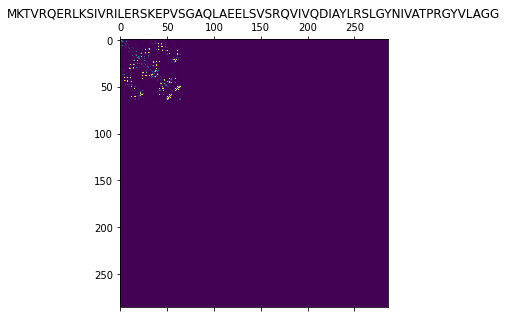

torch.Size([286, 286])


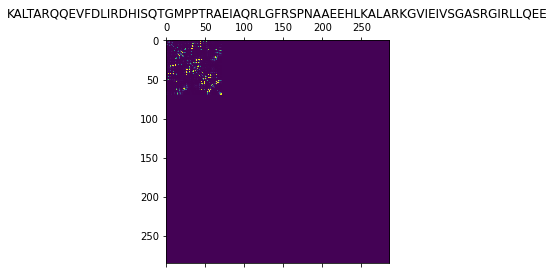

torch.Size([286, 286])


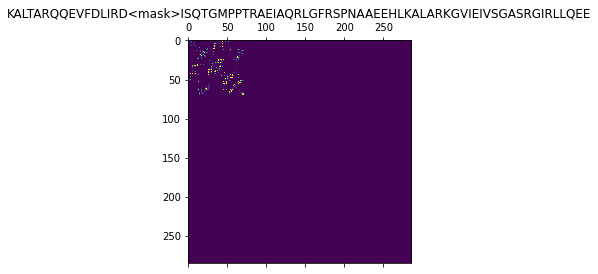

torch.Size([286, 286])


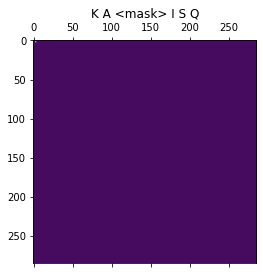

torch.Size([286, 286])


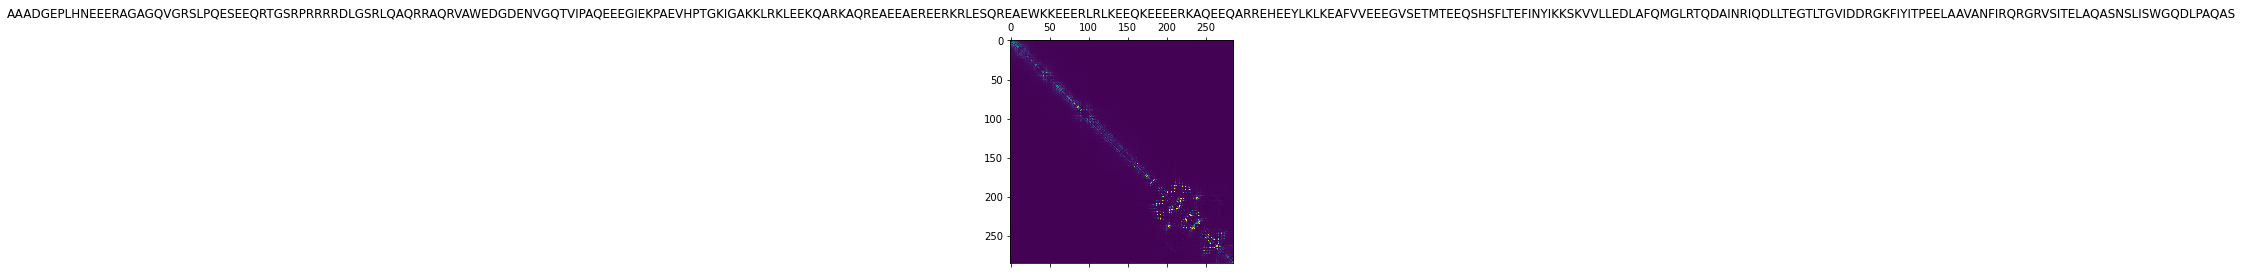

In [7]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    #plt.matshow(attention_contacts[: len(seq), : len(seq)])
    print(attention_contacts.shape)
    plt.matshow(attention_contacts[: , : ])
    plt.title(seq)
    plt.show()

In [8]:
print(results.keys())

dict_keys(['logits', 'representations', 'attentions', 'contacts'])


In [9]:
logits = results['representations']

In [10]:
print(logits[33].shape)

torch.Size([5, 288, 1280])


In [11]:
print(model)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [12]:
print(alphabet)

## Sequence embedding

The paper suggest to average all the hidden states and come to an embedding for the sequence. That is definately the first thing that we can try, but we may be losing some important information. 

We first try this.

In [13]:
newdata = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
]

In [14]:
batch_labels, batch_strs, batch_tokens = batch_converter(newdata)

In [15]:
with torch.no_grad():
    newresults = model(batch_tokens, repr_layers=[32], return_contacts=True)
    
token_representations = newresults["representations"][32]

In [16]:
token_representations.shape

torch.Size([1, 67, 1280])

In [17]:
sequence_representations[0]

tensor([ 0.0614, -0.0687,  0.0430,  ..., -0.1642, -0.0678,  0.0446])

In [18]:
import pandas as pd

In [19]:
df_train = pd.read_csv("./proteindata/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./proteindata/train_updates_20220929.csv", index_col="seq_id")

In [20]:
df_train.shape

(31390, 4)

In [21]:
all_features_nan = df_train_updates.isnull().all("columns")

In [22]:
drop_indices = df_train_updates[all_features_nan].index

In [23]:
drop_indices

Int64Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,
               78,
            ...
            29682, 29787, 29788, 29852, 29853, 30738, 30739, 30740, 30741,
            30742],
           dtype='int64', name='seq_id', length=2409)

In [24]:
df_train = df_train.drop(index=drop_indices)

In [25]:
df_train.shape

(28981, 4)

In [26]:
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [27]:
data = df_train

In [28]:
data.shape

(28981, 4)

In [29]:
x = data['protein_sequence'].tolist()

In [30]:
y = data['tm'].tolist()

In [31]:
ph = data['pH'].tolist()

In [32]:
len(x), len(y), len(ph)

(28981, 28981, 28981)

## Cleaning the training data

I suspect that the protein length > 1000 would not be good for the model. Test data sequence is around 200 in length.
I also think the ESM model does not accept such long sequences. Not sure but I think max is 1024, need to check so we can filter the data and discard longer > 1024 size sequences.


Also filtering for very short sequences < 40... just arbitrary we can change

In [33]:
import math
train_x = []
train_y = []
train_ph = []

for sequence, tm, pH in zip(x, y, ph):
    if math.isnan(pH):
        continue
    if len(sequence) >= 20 and len(sequence) <= 600:
        #if tm < 25 or tm >= 105:
        #    continue
        train_x.append(sequence)
        train_y.append(tm)
        train_ph.append(pH)

In [34]:
x[1]

'AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS'

In [35]:
y[1]

50.5

In [36]:
ph[1]

7.0

In [37]:
len(train_x), len(train_y), len(train_ph)

(22809, 22809, 22809)

In [38]:
sequence_lengths = [len(sequence) for sequence in x]

In [39]:
sequence_lengths[0]

341

In [40]:
import numpy as np
import matplotlib.pyplot as plt

(array([1110., 5588., 5225., 4743., 4117., 2302., 1515., 1060.,  756.,
         619.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

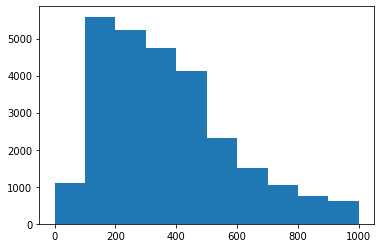

In [41]:
plt.hist(sequence_lengths, range = (0, 1000))

(array([1576.,  277.,   50.,   22.,   17.,    3.,    2.,    3.,    2.,
           0.]),
 array([ 1000.,  1900.,  2800.,  3700.,  4600.,  5500.,  6400.,  7300.,
         8200.,  9100., 10000.]),
 <BarContainer object of 10 artists>)

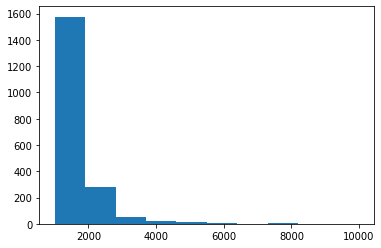

In [42]:
plt.hist(sequence_lengths, range = (1000, 10000))

(array([  3.,   5.,   8.,  13.,  24., 104., 237., 119., 231., 452.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

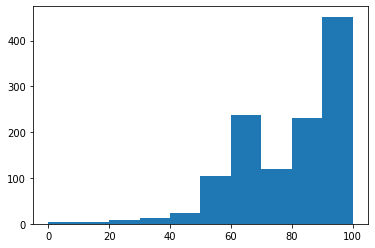

In [43]:
plt.hist(sequence_lengths, range = (0, 100))

In [44]:
len(train_x), len(train_y), len(train_ph)

(22809, 22809, 22809)

In [45]:
train_sequence_lengths = [len(sequence) for sequence in train_x]

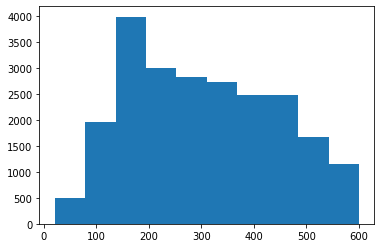

In [46]:
plt.hist(train_sequence_lengths)
plt.show()

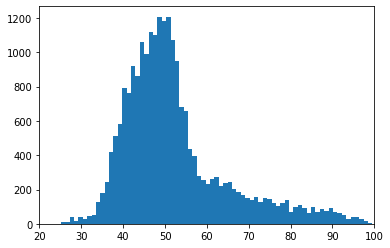

In [47]:
plt.hist(train_y,100)
plt.xlim([20, 100])
plt.show()

In [48]:
counts, bins = np.histogram(train_y, 110, range = (25, 135))

In [49]:
for index, (count_, bin_) in enumerate(zip(counts, bins)):
    print(str(index) + ':' + str(bin_) + ':' + str(count_))

0:25.0:9
1:26.0:10
2:27.0:10
3:28.0:44
4:29.0:18
5:30.0:41
6:31.0:37
7:32.0:49
8:33.0:87
9:34.0:142
10:35.0:194
11:36.0:265
12:37.0:470
13:38.0:468
14:39.0:600
15:40.0:725
16:41.0:795
17:42.0:822
18:43.0:860
19:44.0:922
20:45.0:1015
21:46.0:1045
22:47.0:1065
23:48.0:1105
24:49.0:1128
25:50.0:1162
26:51.0:1066
27:52.0:962
28:53.0:797
29:54.0:600
30:55.0:522
31:56.0:419
32:57.0:356
33:58.0:248
34:59.0:209
35:60.0:246
36:61.0:228
37:62.0:271
38:63.0:205
39:64.0:236
40:65.0:218
41:66.0:213
42:67.0:167
43:68.0:168
44:69.0:139
45:70.0:141
46:71.0:157
47:72.0:131
48:73.0:116
49:74.0:150
50:75.0:128
51:76.0:118
52:77.0:100
53:78.0:115
54:79.0:118
55:80.0:77
56:81.0:89
57:82.0:112
58:83.0:76
59:84.0:69
60:85.0:89
61:86.0:69
62:87.0:77
63:88.0:75
64:89.0:84
65:90.0:72
66:91.0:67
67:92.0:46
68:93.0:33
69:94.0:36
70:95.0:36
71:96.0:33
72:97.0:19
73:98.0:10
74:99.0:1
75:100.0:0
76:101.0:0
77:102.0:0
78:103.0:2
79:104.0:0
80:105.0:0
81:106.0:0
82:107.0:0
83:108.0:1
84:109.0:1
85:110.0:0
86:111.0:1
8

In [50]:
maxCount = max(counts)
print(maxCount)

1162


In [51]:
train_repsToStratify = [] 
reps = 0
for x, y, pH in zip(train_x, train_y, train_ph):
    #if y < 20 or y >= 100:
    #    continue
    bin_index = int(1 * (y - 25))
    bin_count = counts[bin_index]
    if bin_count == 0:
        train_repsToStratify.append(0)
    else:
        repToStratify = int((maxCount // bin_count) * 0.8) + 1
        print('y: ' + str(y) + ' counts: ' + str(bin_count) + ' reps to stratify: ' + str(repToStratify))
        train_repsToStratify.append(repToStratify)

y: 75.7 counts: 128 reps to stratify: 8
y: 50.5 counts: 1162 reps to stratify: 1
y: 40.5 counts: 725 reps to stratify: 1
y: 47.2 counts: 1065 reps to stratify: 1
y: 48.4 counts: 1105 reps to stratify: 1
y: 45.7 counts: 1015 reps to stratify: 1
y: 55.9 counts: 522 reps to stratify: 2
y: 48.1 counts: 1105 reps to stratify: 1
y: 49.7 counts: 1128 reps to stratify: 1
y: 45.1 counts: 1015 reps to stratify: 1
y: 60.6 counts: 246 reps to stratify: 4
y: 62.8 counts: 271 reps to stratify: 4
y: 36.3 counts: 265 reps to stratify: 4
y: 44.7 counts: 922 reps to stratify: 1
y: 83.0 counts: 76 reps to stratify: 13
y: 43.3 counts: 860 reps to stratify: 1
y: 44.3 counts: 922 reps to stratify: 1
y: 42.5 counts: 822 reps to stratify: 1
y: 37.9 counts: 470 reps to stratify: 2
y: 65.1 counts: 218 reps to stratify: 5
y: 44.5 counts: 922 reps to stratify: 1
y: 50.6 counts: 1162 reps to stratify: 1
y: 65.4 counts: 218 reps to stratify: 5
y: 37.9 counts: 470 reps to stratify: 2
y: 45.2 counts: 1015 reps to str

In [52]:
len(train_repsToStratify)

22809

## Changing the sequence to embedding vector

First define a function..
averaging hidden states of the last layer... we may be losing some important information

In [53]:
def ESMembedding(input_sequence):
    input_data = [("protein1", input_sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(input_data)
    batch_labels, batch_strs, batch_tokens = batch_labels, batch_strs, batch_tokens.cuda()
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    sequence_representations = token_representations[0, 1 : len(input_sequence) + 1].mean(0)
    return sequence_representations.cpu().numpy()

In [54]:
model = model.cuda()

In [55]:
test_embedding = ESMembedding(train_x[0])

In [56]:
test_embedding

array([ 0.07047152, -0.10383302, -0.00030396, ..., -0.08737316,
       -0.00137351,  0.04592499], dtype=float32)

In [57]:
len(test_embedding)

1280

In [58]:
ph_ = np.array(train_ph[0])

In [59]:
ph_

array(7.)

In [60]:
test_embedding = np.hstack([test_embedding, ph_])

In [61]:
test_embedding

array([ 7.04715177e-02, -1.03833020e-01, -3.03955720e-04, ...,
       -1.37351162e-03,  4.59249876e-02,  7.00000000e+00])

In [62]:
torch.cuda.empty_cache()

In [63]:
# Uncomment the lines in the below if you dont have save embeddings

In [64]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 1906),
             ('active.all.current', 637),
             ('active.all.freed', 1269),
             ('active.all.peak', 684),
             ('active.large_pool.allocated', 1108),
             ('active.large_pool.current', 199),
             ('active.large_pool.freed', 909),
             ('active.large_pool.peak', 240),
             ('active.small_pool.allocated', 798),
             ('active.small_pool.current', 438),
             ('active.small_pool.freed', 360),
             ('active.small_pool.peak', 446),
             ('active_bytes.all.allocated', 7610672640),
             ('active_bytes.all.current', 2679209472),
             ('active_bytes.all.freed', 4931463168),
             ('active_bytes.all.peak', 4536413696),
             ('active_bytes.large_pool.allocated', 7536453120),
             ('active_bytes.large_pool.current', 2670985216),
             ('active_bytes.large_pool.freed', 4865467904),
             ('active_bytes.large_pool.peak

In [65]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    2555 MB |    4326 MB |    7258 MB |    4703 MB |\n|       from large pool |    2547 MB |    4316 MB |    7187 MB |    4640 MB |\n|       from small pool |       7 MB |      10 MB |      70 MB |      62 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    2555 MB |    4326 MB |    7258 MB |    4703 MB |\n|       from large pool |    2547 MB |    4316 MB |

In [66]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:4096'

In [67]:
train_x_embed_stratified = []
train_y_stratified = []
train_ph_stratified = []

for i, (sequence, y, pH) in enumerate(zip(train_x, train_y, train_ph)):
    if i % 100 == 0:
        print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    for reps in range(train_repsToStratify[i]):
        train_x_embed_stratified.append(embed)
        train_y_stratified.append(y)
        train_ph_stratified.append(pH)

Working on sequence 0...
Working on sequence 100...
Working on sequence 200...
Working on sequence 300...
Working on sequence 400...
Working on sequence 500...
Working on sequence 600...
Working on sequence 700...
Working on sequence 800...
Working on sequence 900...
Working on sequence 1000...
Working on sequence 1100...
Working on sequence 1200...
Working on sequence 1300...
Working on sequence 1400...
Working on sequence 1500...
Working on sequence 1600...
Working on sequence 1700...
Working on sequence 1800...
Working on sequence 1900...
Working on sequence 2000...
Working on sequence 2100...
Working on sequence 2200...
Working on sequence 2300...
Working on sequence 2400...
Working on sequence 2500...
Working on sequence 2600...
Working on sequence 2700...
Working on sequence 2800...
Working on sequence 2900...
Working on sequence 3000...
Working on sequence 3100...
Working on sequence 3200...
Working on sequence 3300...
Working on sequence 3400...
Working on sequence 3500...
Work

### trying to save these

In [68]:
import pickle

with open("train_x_embed_stratified_latest.pl", "wb") as fp:   #Pickling
    pickle.dump(train_x_embed_stratified, fp)

In [ ]:
import pickle
with open("train_x_embed_stratified_latest.pl", "rb") as fp:
    # Unpickling
    train_x_embed_stratified = pickle.load(fp)

In [69]:
len(train_x_embed_stratified)

77231

In [70]:
train_x_embed_stratified[0].shape

(1280,)

In [71]:
len(train_x_embed_stratified)

77231

In [72]:
train_x_embed_stratified_new = [x.reshape([1, -1]) for x in train_x_embed_stratified]

In [73]:
train_x_embed_stratified_new2 = np.vstack(train_x_embed_stratified_new)

In [74]:
train_x_embed_stratified_new2.shape

(77231, 1280)

In [ ]:
#This is not needed anymore after dataset fix

import math

average_pH = np.nanmean(np.array(train_ph_stratified))
print(average_pH)

count = 0

for index, p in enumerate(train_ph_stratified):
    if math.isnan(p):
        train_ph_stratified[index] = average_pH

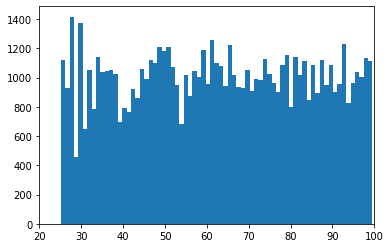

In [75]:
plt.hist(train_y_stratified,100)
plt.xlim([25, 125])
plt.show()

In [76]:
print(len(train_x))
print(len(train_y))
print(len(train_ph))

22809
22809
22809


In [77]:
train_x.clear()
train_y.clear()
train_ph.clear()

In [78]:
print(len(train_x_embed_stratified))
print(len(train_y_stratified))
print(len(train_ph_stratified))

77231
77231
77231


In [79]:
train_ph_stratified_list = np.array(train_ph_stratified).reshape([-1, 1])

In [80]:
print(len(train_ph_stratified))
train_ph_stratified.clear()
print(len(train_ph_stratified))

77231
0


In [81]:
train_ph_stratified_list.shape

(77231, 1)

In [82]:
train_ph_stratified_list = train_ph_stratified_list / 14

In [83]:
train_x_embed_stratified_with_ph = np.hstack([train_x_embed_stratified_new2, train_ph_stratified_list])

In [84]:
train_x_embed_stratified_with_ph.shape

(77231, 1281)

In [85]:
train_x_embed_stratified_with_ph[112]

array([ 0.08855153, -0.12198227, -0.06630865, ...,  0.0595332 ,
       -0.11209799,  0.5       ])

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x_embed_stratified_with_ph, train_y_stratified, test_size=0.1, random_state=42, shuffle = True)

In [87]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_x_embed_stratified_with_ph', 791463416),
 ('X_train', 712307864),
 ('train_x_embed_stratified_new2', 395422848),
 ('X_test', 79155680),
 ('data', 18971748),
 ('df_train', 18971748),
 ('train_x_embed_stratified', 651344),
 ('train_x_embed_stratified_new', 651344),
 ('train_y_stratified', 651344),
 ('train_ph_stratified_list', 617976),
 ('y_train', 578928),
 ('sequence_lengths', 253624),
 ('ph', 231904),
 ('df_train_updates', 225013),
 ('train_repsToStratify', 200312),
 ('train_sequence_lengths', 200312),
 ('all_features_nan', 88010),
 ('y_test', 69152),
 ('drop_indices', 19288),
 ('test_embedding', 10360),
 ('counts', 992),
 ('sequence', 586),
 ('x', 586),
 ('seq', 335),
 ('logits', 232),
 ('newresults', 232),
 ('results', 232),
 ('swap_ph_tm_indices', 216),
 ('fp', 168),
 ('ESMembedding', 136),
 ('train_test_split', 136),
 ('sequence_representations', 120),
 ('bins', 112),
 ('embed', 112),
 ('ph_', 104),
 ('batch_labels', 88),
 ('batch_strs', 88),
 ('attention_contacts', 72),


In [88]:
del train_x_embed_stratified_with_ph
del train_x_embed_stratified_new2
del data
del df_train
del train_x_embed_stratified
del train_x_embed_stratified_new

## Things to try:
- GBM
- Random forrest
- kNN regression

In [89]:
X_train.shape

(69507, 1281)

In [90]:
X_train[0]

array([ 0.05173805, -0.06133159, -0.01312   , ...,  0.01988917,
        0.00614086,  0.5       ])

In [92]:
from sklearn.neighbors import KNeighborsRegressor
kNN = KNeighborsRegressor(n_neighbors = 10, weights = 'uniform')
kNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [93]:
y_test_hat = kNN.predict(X_test)

In [94]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_test_hat)

print(MSE ** 0.5)

5.913490406317011


In [95]:
print(y_test_hat[:20])

[56.5  60.32 64.36 98.3  58.37 69.3  96.5  99.   52.58 81.26 28.5  34.87
 48.32 44.14 87.   33.55 36.5  27.9  72.5  60.48]


In [96]:
print(y_test[:20])

[55.9, 66.5, 65.0, 98.3, 58.9, 69.6, 96.5, 99.0, 49.6, 81.6, 29.6, 44.5, 47.7, 49.2, 87.0, 33.7, 58.9, 27.9, 65.5, 65.5]


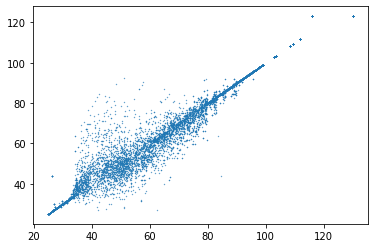

In [97]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_test_hat, s = .1)
plt.show()

In [98]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

corr, _ = pearsonr(y_test, y_test_hat)
print('Pearsons correlation: %.3f' % corr)

r2_score_ = r2_score(y_test, y_test_hat)
print('r2 score: %.3f' % r2_score_)

Pearsons correlation: 0.970
r2 score: 0.941


# Pytorch

In [99]:
import torch
from torch import nn
from torch import optim

#input_dim = 1281
input_dim = 1281 * 2

hidden_dim = 650
hidden_dim2 = 200
hidden_dim3 = 50

output_dim = 1

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.fc1.weight)
        #self.norm1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        nn.init.xavier_uniform_(self.fc2.weight)
        #self.norm2 = nn.BatchNorm1d(hidden_dim2)
        
        #self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim2, output_dim)
        nn.init.xavier_uniform_(self.fc4.weight)
       
    def forward(self, x):
        #x = torch.nn.functional.relu(self.norm1(self.fc1(x)))
        x = torch.nn.functional.relu(self.fc1(x))
        
        x = torch.nn.functional.relu(self.fc2(x))
        
        #x = self.fc3(x)
        x = self.fc4(x)

        return x
       
modelnn = Net(input_dim, hidden_dim, output_dim)
print(modelnn)

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)


In [100]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Available device: " + device)
device = torch.device(device)
modelnn = modelnn.to(device)
learning_rate = 0.0005

loss_fn = nn.MSELoss()
#loss_fn = nn.MarginRankingLoss()

optimizer = torch.optim.Adam(modelnn.parameters(), lr=learning_rate)

loss_fn = loss_fn.to(device)
print(device)

Available device: cuda:0
cuda:0


In [101]:
import random

In [103]:
%autosave 0

Autosave disabled


In [104]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize'))

In [106]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [107]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [108]:
X_train.shape

(69507, 1281)

In [109]:
len(y_train)

69507

In [110]:
y_train_np = np.array(y_train)

In [111]:
y_train_np_normalized = y_train_np / 100

In [112]:
y_train_np_normalized.shape

(69507,)

In [113]:
X_train_torch = torch.from_numpy(X_train.astype(np.float32)).to(device)

In [114]:
y_train_torch = torch.from_numpy(y_train_np_normalized.astype(np.float32)).to(device)

In [115]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [117]:
batch_size = 512

In [118]:
train_data = DataFromTorch(X_train_torch, y_train_torch)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [119]:
X_train_torch.shape

torch.Size([69507, 1281])

In [120]:
y_train_torch.shape

torch.Size([69507])

In [121]:
y_train_torch[:10]

tensor([0.7730, 0.8320, 1.0950, 0.6200, 0.8070, 0.6120, 0.3670, 0.4670, 0.9390,
        0.7660], device='cuda:0')

In [123]:
device

device(type='cuda', index=0)

In [124]:
modelnn.to(device)

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)

In [311]:
print('starting the cell')
num_outer_epochs = 10
num_epochs = 10
#loss_values = []
modelnn.train()


#SamplesPerTraining = 4
NumberTraings = X_train.shape[0]

print('Starting the outer loop...')
for outer_epoch in range(num_outer_epochs):
    
    Epoch_loss = 0
    
    for index, (X1, y1) in enumerate(train_dataloader):
        #print(X1.shape)
        #print(y1.shape)
        
        random_list = torch.randperm(X_train_torch.shape[0])[:X1.shape[0]]
        #print(random_list.shape)
        #print(random_list)
        X2 = X_train_torch[random_list]
        #print('X2 works and its shape is ' + str(X2.shape))
            
        X = torch.cat((X1, X2), 1)
        #print('X works and its shape is ' + str(X.shape))
            
        y2 = y_train_torch[random_list]
        #print('y2 works and its shape is ' + str(y2.shape))
        
        Batch_loss = 0
        
        for epoch in range(num_epochs):
            
            optimizer.zero_grad()
            pred = modelnn(X)
            y    = (y1-y2).unsqueeze(-1)
            loss = loss_fn(pred, y)
            Batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            
        
        Epoch_loss += Batch_loss
        #print('Batch: ' + str(index) + '\t Loss: ' + str(Batch_loss))
            
    print('Epoch: ' + str(outer_epoch) + '\t Loss: ' + str(Epoch_loss))   

starting the cell
Starting the outer loop...
Epoch: 0	 Loss: 2.0111775381374173
Epoch: 1	 Loss: 2.180390372814145
Epoch: 2	 Loss: 2.192121047875844
Epoch: 3	 Loss: 2.2202365480479784
Epoch: 4	 Loss: 2.2147395380889066
Epoch: 5	 Loss: 2.2216876875027083
Epoch: 6	 Loss: 2.1927887288620695
Epoch: 7	 Loss: 2.1199940758524463
Epoch: 8	 Loss: 2.2117914235568605
Epoch: 9	 Loss: 2.2328224951052107


In [367]:
#torch.save(modelnn.state_dict(), 'DualLoopModel_AlwaysRandomize3')

In [352]:
#modelnn.load_state_dict(torch.load('DualLoopModel_Good3_p15'))

<All keys matched successfully>

In [312]:
X_train_torch.shape

torch.Size([69507, 1281])

In [313]:
y_train_torch.shape

torch.Size([69507])

In [314]:
X_test_torch = torch.from_numpy(X_test.astype(np.float32)).to(device)

In [315]:
y_test_np = np.array(y_test)
y_test_np_normalized = y_test_np / 100
y_test_torch = torch.from_numpy(y_test_np_normalized.astype(np.float32)).to(device)

In [316]:
X_test_torch.shape, y_test_torch.shape

(torch.Size([7724, 1281]), torch.Size([7724]))

# Regression

In [317]:
modelnn.eval()

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)

In [478]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize3'))

<All keys matched successfully>

In [666]:
def getDualRegressionFromEmbedding(embed):
    x_array = []
    y_array = []
    target_array = []
    #print(embed)
    
    preds = []
    preds_rev = []
    ys    = []
    for index, (X1, y1) in enumerate(train_dataloader):
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
        X2 = torch.from_numpy(embed.astype(np.float32)).to(device).unsqueeze(0).repeat(X1.shape[0], 1)
        #X2 = torch.from_numpy(embed.repeat(X1.shape[0]).reshape(X1.shape[0], -1).astype(np.float32)).to(device)
        #print('X2 works and its shape is ' + str(X2.shape))
        #print(X2)
        
            
        X = torch.cat((X1, X2), 1)
        X_rev = torch.cat((X2, X1), 1)
        
        #print('X works and its shape is ' + str(X.shape))
        #print(X)
        with torch.no_grad():
            pred = modelnn(X)
            pred_rev = modelnn(X_rev)
        
        #print('prediction success and shape of output ' + str(pred.shape))
        
        preds.append(pred)
        preds_rev.append(pred_rev)
        ys.append(y1)
        
        
        
    return torch.cat(preds, dim=0).detach().cpu().numpy(), torch.cat(preds_rev, dim=0).detach().cpu().numpy(), torch.cat(ys, dim=0).detach().cpu().numpy()
    

In [604]:
embed = X_train[index]

In [605]:
X2 = torch.from_numpy(embed.astype(np.float32)).to(device)

In [606]:
X2.shape

torch.Size([1281])

In [607]:
X3 = X2.unsqueeze(0)

In [608]:
X3.shape

torch.Size([1, 1281])

In [609]:
X4 = X3.repeat(512, 1)

In [610]:
X4.shape

torch.Size([512, 1281])

In [611]:
X4[0]

tensor([-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
       device='cuda:0')

In [612]:
X4[1]

tensor([-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
       device='cuda:0')

In [613]:
torch.cuda.empty_cache() 

In [614]:
index = 55
X_train[index], y_train_np_normalized[index] * 100

(array([-0.00427651, -0.02237162, -0.05303773, ..., -0.04368795,
        -0.01674729,  0.5       ]),
 34.4)

In [615]:
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(X_train[index])

[-0.00427651 -0.02237162 -0.05303773 ... -0.04368795 -0.01674729
  0.5       ]
tensor([[-0.0027, -0.1175,  0.0180,  ..., -0.0505,  0.0559,  0.5000],
        [ 0.0030, -0.1020, -0.0368,  ...,  0.0140,  0.0391,  0.5000],
        [ 0.0843, -0.1386, -0.0203,  ..., -0.0330,  0.2833,  0.1571],
        ...,
        [ 0.0482,  0.1222,  0.0135,  ...,  0.0552,  0.0676,  0.5000],
        [ 0.0861, -0.0088, -0.0068,  ..., -0.0215,  0.0690,  0.5000],
        [ 0.0491, -0.0611, -0.0072,  ..., -0.0264, -0.0218,  0.5000]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        

tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='cuda:0')
X works and its shape is torch.Size([512, 2562])
tensor([[ 0.0457, -0.0397,  0.0534,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0510, -0.0933, -0.0325,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0837, -0.1411, -0.0216,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0708, -0.1477, -0.0645,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0745,  0.0514,  0.0413,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0297, -0.0279, -0.0518,  ..., -0.0437, -0.0167,  0.5000]],
       device='cuda:0')
tensor([[ 0.0383, -0.1667,  0.0118,

tensor([[ 0.0864, -0.1461, -0.0589,  ..., -0.0048, -0.0283,  0.5000],
        [ 0.0806, -0.1422, -0.0207,  ..., -0.0339,  0.2789,  0.3071],
        [ 0.0115, -0.1245, -0.0487,  ...,  0.0265,  0.1612,  0.3929],
        ...,
        [-0.0356, -0.0270,  0.0347,  ..., -0.0374,  0.1021,  0.5000],
        [-0.0055, -0.1059, -0.0786,  ..., -0.0386,  0.1111,  0.6486],
        [ 0.0725, -0.0884, -0.0081,  ...,  0.0286,  0.0269,  0.5000]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='c

tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='cuda:0')
X works and its shape is torch.Size([512, 2562])
tensor([[ 0.0341,  0.0416, -0.0135,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0027, -0.0560, -0.0041,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0028,  0.0173, -0.0175,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [ 0.0246, -0.0584,  0.0323,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0029,  0.0229,  0.0528,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0668,  0.0052, -0.0047,  ..., -0.0437, -0.0167,  0.5000]],
       device='cuda:0')
tensor([[ 0.0227, -0.0997,  0.0328,

tensor([[ 0.0150, -0.0449, -0.0319,  ...,  0.0179,  0.0319,  0.5000],
        [ 0.0629, -0.1025, -0.0089,  ..., -0.0119,  0.1604,  0.5000],
        [ 0.0083, -0.0183, -0.0100,  ...,  0.0059,  0.1322,  0.5000],
        ...,
        [ 0.0650,  0.0221,  0.0713,  ..., -0.0349,  0.0103,  0.5000],
        [-0.0068, -0.0912, -0.0769,  ..., -0.0388,  0.1021,  0.6486],
        [ 0.0042, -0.0731, -0.0186,  ..., -0.0042,  0.2012,  0.5000]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='c

tensor([[-0.0105, -0.0029,  0.0469,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0387, -0.0412, -0.0279,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0347, -0.0742, -0.0312,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [ 0.0472, -0.0082,  0.0586,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0584, -0.0755, -0.0055,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0525, -0.0823, -0.0279,  ..., -0.0437, -0.0167,  0.5000]],
       device='cuda:0')
tensor([[ 0.0151, -0.0930,  0.0132,  ...,  0.0274,  0.0657,  0.4500],
        [-0.0019, -0.0140,  0.0224,  ...,  0.0239,  0.0204,  0.5000],
        [ 0.0498, -0.0452, -0.0173,  ..., -0.0188,  0.0678,  0.5000],
        ...,
        [-0.0304, -0.0147, -0.0303,  ..., -0.0495,  0.1141,  0.5000],
        [-0.0307,  0.0291,  0.0031,  ..., -0.0532,  0.0312,  0.5286],
        [ 0.0875, -0.1646, -0.0128,  ..., -0.0393, -0.0605,  0.5000]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512,

tensor([[ 0.0738,  0.0225,  0.0190,  ..., -0.0385,  0.1452,  0.5000],
        [ 0.0429, -0.0560, -0.0211,  ..., -0.0271,  0.1047,  0.5429],
        [ 0.1014, -0.1380, -0.0423,  ...,  0.0341, -0.0030,  0.5000],
        ...,
        [ 0.0486, -0.2007, -0.0012,  ..., -0.0015,  0.0307,  0.5000],
        [ 0.0330, -0.0075, -0.0560,  ...,  0.0330,  0.0145,  0.5000],
        [ 0.0806, -0.0397,  0.0577,  ...,  0.0285,  0.0816,  0.5000]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='c

tensor([[ 0.0829, -0.1354, -0.0251,  ..., -0.0333,  0.2852,  0.1429],
        [-0.0188, -0.0660,  0.0501,  ..., -0.0796,  0.1446,  0.5000],
        [ 0.0763, -0.1355,  0.0126,  ...,  0.0242, -0.0755,  0.5000],
        ...,
        [-0.0063, -0.0407,  0.0274,  ...,  0.0422,  0.0724,  0.5571],
        [ 0.0926, -0.0797, -0.0344,  ..., -0.1304, -0.0676,  0.3286],
        [-0.0068, -0.0912, -0.0769,  ..., -0.0388,  0.1021,  0.6486]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='c

X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='cuda:0')
X works and its shape is torch.Size([512, 2562])
tensor([[ 0.0311, -0.0992, -0.0390,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0132, -0.0780,  0.0133,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.1123, -0.1470,  0.0005,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [ 0.0457, -0.1556, -0.0098,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0401, -0.1047,  0.0995,  ..., -0.0437, -0.0167,  0.5000],
        [ 0.0384,  0.0121,  0.0133,  ..., -0.0437, -0.0167,  0.5000]],
       de

tensor([[ 0.0327,  0.0188, -0.0160,  ..., -0.0428,  0.0245,  0.5000],
        [ 0.0326, -0.1471, -0.0581,  ..., -0.0672,  0.1240,  0.1929],
        [ 0.0065, -0.0533,  0.0163,  ..., -0.0493,  0.0784,  0.5000],
        ...,
        [ 0.0350, -0.0358,  0.0223,  ..., -0.0093,  0.1258,  0.5000],
        [ 0.0105, -0.0408, -0.0366,  ..., -0.0386,  0.1501,  0.5000],
        [-0.0354, -0.0386,  0.0043,  ...,  0.0399, -0.0731,  0.5357]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='c

tensor([[ 0.0644,  0.0230,  0.0243,  ..., -0.0245,  0.0686,  0.5000],
        [ 0.0142, -0.0830,  0.0175,  ...,  0.0380,  0.0743,  0.4500],
        [ 0.0587,  0.0330,  0.0088,  ...,  0.0134,  0.0006,  0.5000],
        ...,
        [ 0.0086, -0.1269, -0.0257,  ...,  0.0317,  0.1711,  0.3929],
        [ 0.0113, -0.0493, -0.0600,  ..., -0.0433,  0.0120,  0.5000],
        [ 0.0810, -0.0222, -0.0314,  ..., -0.0918,  0.0155,  0.5000]],
       device='cuda:0')
torch.Size([512, 1281])
torch.Size([512])
X2 works and its shape is torch.Size([512, 1281])
tensor([[-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        ...,
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000],
        [-0.0043, -0.0224, -0.0530,  ..., -0.0437, -0.0167,  0.5000]],
       device='c

In [624]:
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

In [625]:
res.shape

(69507, 1)

In [626]:
res_np = res

In [627]:
res_np.shape

(69507, 1)

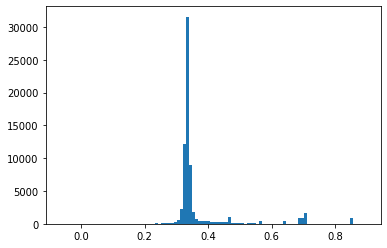

In [628]:
plt.hist(res_np,100)
#plt.xlim([25, 125])
plt.show()

In [629]:
np.mean(res_np) * 100

36.81633472442627

# COMPETITION DATA

In [632]:
competition_data = pd.read_csv('./proteindata/test.csv', index_col = False)

In [633]:
competition_data

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [634]:
x_competition = competition_data['protein_sequence'].tolist()

In [635]:
ph_competition = competition_data['pH'].tolist()

# Dont run the cell below if you have the competition embeddings saved!


In [636]:
x_competition_embed  = []

for i, sequence in enumerate(x_competition):
    print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    x_competition_embed.append(embed)

Working on sequence 0...
Working on sequence 1...
Working on sequence 2...
Working on sequence 3...
Working on sequence 4...
Working on sequence 5...
Working on sequence 6...
Working on sequence 7...
Working on sequence 8...
Working on sequence 9...
Working on sequence 10...
Working on sequence 11...
Working on sequence 12...
Working on sequence 13...
Working on sequence 14...
Working on sequence 15...
Working on sequence 16...
Working on sequence 17...
Working on sequence 18...
Working on sequence 19...
Working on sequence 20...
Working on sequence 21...
Working on sequence 22...
Working on sequence 23...
Working on sequence 24...
Working on sequence 25...
Working on sequence 26...
Working on sequence 27...
Working on sequence 28...
Working on sequence 29...
Working on sequence 30...
Working on sequence 31...
Working on sequence 32...
Working on sequence 33...
Working on sequence 34...
Working on sequence 35...
Working on sequence 36...
Working on sequence 37...
Working on sequence 38

Working on sequence 312...
Working on sequence 313...
Working on sequence 314...
Working on sequence 315...
Working on sequence 316...
Working on sequence 317...
Working on sequence 318...
Working on sequence 319...
Working on sequence 320...
Working on sequence 321...
Working on sequence 322...
Working on sequence 323...
Working on sequence 324...
Working on sequence 325...
Working on sequence 326...
Working on sequence 327...
Working on sequence 328...
Working on sequence 329...
Working on sequence 330...
Working on sequence 331...
Working on sequence 332...
Working on sequence 333...
Working on sequence 334...
Working on sequence 335...
Working on sequence 336...
Working on sequence 337...
Working on sequence 338...
Working on sequence 339...
Working on sequence 340...
Working on sequence 341...
Working on sequence 342...
Working on sequence 343...
Working on sequence 344...
Working on sequence 345...
Working on sequence 346...
Working on sequence 347...
Working on sequence 348...
W

Working on sequence 617...
Working on sequence 618...
Working on sequence 619...
Working on sequence 620...
Working on sequence 621...
Working on sequence 622...
Working on sequence 623...
Working on sequence 624...
Working on sequence 625...
Working on sequence 626...
Working on sequence 627...
Working on sequence 628...
Working on sequence 629...
Working on sequence 630...
Working on sequence 631...
Working on sequence 632...
Working on sequence 633...
Working on sequence 634...
Working on sequence 635...
Working on sequence 636...
Working on sequence 637...
Working on sequence 638...
Working on sequence 639...
Working on sequence 640...
Working on sequence 641...
Working on sequence 642...
Working on sequence 643...
Working on sequence 644...
Working on sequence 645...
Working on sequence 646...
Working on sequence 647...
Working on sequence 648...
Working on sequence 649...
Working on sequence 650...
Working on sequence 651...
Working on sequence 652...
Working on sequence 653...
W

Working on sequence 923...
Working on sequence 924...
Working on sequence 925...
Working on sequence 926...
Working on sequence 927...
Working on sequence 928...
Working on sequence 929...
Working on sequence 930...
Working on sequence 931...
Working on sequence 932...
Working on sequence 933...
Working on sequence 934...
Working on sequence 935...
Working on sequence 936...
Working on sequence 937...
Working on sequence 938...
Working on sequence 939...
Working on sequence 940...
Working on sequence 941...
Working on sequence 942...
Working on sequence 943...
Working on sequence 944...
Working on sequence 945...
Working on sequence 946...
Working on sequence 947...
Working on sequence 948...
Working on sequence 949...
Working on sequence 950...
Working on sequence 951...
Working on sequence 952...
Working on sequence 953...
Working on sequence 954...
Working on sequence 955...
Working on sequence 956...
Working on sequence 957...
Working on sequence 958...
Working on sequence 959...
W

Working on sequence 1224...
Working on sequence 1225...
Working on sequence 1226...
Working on sequence 1227...
Working on sequence 1228...
Working on sequence 1229...
Working on sequence 1230...
Working on sequence 1231...
Working on sequence 1232...
Working on sequence 1233...
Working on sequence 1234...
Working on sequence 1235...
Working on sequence 1236...
Working on sequence 1237...
Working on sequence 1238...
Working on sequence 1239...
Working on sequence 1240...
Working on sequence 1241...
Working on sequence 1242...
Working on sequence 1243...
Working on sequence 1244...
Working on sequence 1245...
Working on sequence 1246...
Working on sequence 1247...
Working on sequence 1248...
Working on sequence 1249...
Working on sequence 1250...
Working on sequence 1251...
Working on sequence 1252...
Working on sequence 1253...
Working on sequence 1254...
Working on sequence 1255...
Working on sequence 1256...
Working on sequence 1257...
Working on sequence 1258...
Working on sequence 

Working on sequence 1521...
Working on sequence 1522...
Working on sequence 1523...
Working on sequence 1524...
Working on sequence 1525...
Working on sequence 1526...
Working on sequence 1527...
Working on sequence 1528...
Working on sequence 1529...
Working on sequence 1530...
Working on sequence 1531...
Working on sequence 1532...
Working on sequence 1533...
Working on sequence 1534...
Working on sequence 1535...
Working on sequence 1536...
Working on sequence 1537...
Working on sequence 1538...
Working on sequence 1539...
Working on sequence 1540...
Working on sequence 1541...
Working on sequence 1542...
Working on sequence 1543...
Working on sequence 1544...
Working on sequence 1545...
Working on sequence 1546...
Working on sequence 1547...
Working on sequence 1548...
Working on sequence 1549...
Working on sequence 1550...
Working on sequence 1551...
Working on sequence 1552...
Working on sequence 1553...
Working on sequence 1554...
Working on sequence 1555...
Working on sequence 

Working on sequence 1817...
Working on sequence 1818...
Working on sequence 1819...
Working on sequence 1820...
Working on sequence 1821...
Working on sequence 1822...
Working on sequence 1823...
Working on sequence 1824...
Working on sequence 1825...
Working on sequence 1826...
Working on sequence 1827...
Working on sequence 1828...
Working on sequence 1829...
Working on sequence 1830...
Working on sequence 1831...
Working on sequence 1832...
Working on sequence 1833...
Working on sequence 1834...
Working on sequence 1835...
Working on sequence 1836...
Working on sequence 1837...
Working on sequence 1838...
Working on sequence 1839...
Working on sequence 1840...
Working on sequence 1841...
Working on sequence 1842...
Working on sequence 1843...
Working on sequence 1844...
Working on sequence 1845...
Working on sequence 1846...
Working on sequence 1847...
Working on sequence 1848...
Working on sequence 1849...
Working on sequence 1850...
Working on sequence 1851...
Working on sequence 

Working on sequence 2111...
Working on sequence 2112...
Working on sequence 2113...
Working on sequence 2114...
Working on sequence 2115...
Working on sequence 2116...
Working on sequence 2117...
Working on sequence 2118...
Working on sequence 2119...
Working on sequence 2120...
Working on sequence 2121...
Working on sequence 2122...
Working on sequence 2123...
Working on sequence 2124...
Working on sequence 2125...
Working on sequence 2126...
Working on sequence 2127...
Working on sequence 2128...
Working on sequence 2129...
Working on sequence 2130...
Working on sequence 2131...
Working on sequence 2132...
Working on sequence 2133...
Working on sequence 2134...
Working on sequence 2135...
Working on sequence 2136...
Working on sequence 2137...
Working on sequence 2138...
Working on sequence 2139...
Working on sequence 2140...
Working on sequence 2141...
Working on sequence 2142...
Working on sequence 2143...
Working on sequence 2144...
Working on sequence 2145...
Working on sequence 

Working on sequence 2406...
Working on sequence 2407...
Working on sequence 2408...
Working on sequence 2409...
Working on sequence 2410...
Working on sequence 2411...
Working on sequence 2412...


In [637]:
import pickle

with open("competition_embeds_pl_new", "wb") as fp:   #Pickling
    #pickle.dump(x_competition_embed, fp)

# Instead load the saved embeddings!


In [638]:
import pickle
with open("competition_embeds_pl_new", "rb") as fp:
    x_competition_embed = pickle.load(fp)

In [639]:
x_competition[:5]

['VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPK

In [640]:
x_competition_embed[:5]

[array([-0.05348419, -0.0577033 , -0.15324247, ..., -0.10081477,
         0.00437558,  0.10947983], dtype=float32),
 array([-0.05385044, -0.05386613, -0.16091336, ..., -0.094506  ,
         0.00279988,  0.1078918 ], dtype=float32),
 array([-0.05591825, -0.05563816, -0.15555942, ..., -0.10034766,
         0.00449493,  0.10842798], dtype=float32),
 array([-0.05603744, -0.04441665, -0.15105218, ..., -0.09418205,
        -0.00062137,  0.10995836], dtype=float32),
 array([-0.05250967, -0.04570286, -0.14952633, ..., -0.08603902,
        -0.00391663,  0.11597865], dtype=float32)]

In [642]:
x_competition_embed_new = [x.reshape([1, -1]) for x in x_competition_embed]

In [643]:
x_competition_embed_new2 = np.vstack(x_competition_embed_new)

In [644]:
train_ph_list = np.array(ph_competition).reshape([-1, 1])

In [645]:
train_ph_np_normalized = train_ph_list / 14

In [646]:
x_competition_embed_with_ph = np.hstack([x_competition_embed_new2, train_ph_np_normalized])

In [647]:
x_competition_embed_with_ph.shape

(2413, 1281)

In [648]:
x_competition_embed_with_ph[:5]

array([[-0.05348419, -0.0577033 , -0.15324247, ...,  0.00437558,
         0.10947983,  0.57142857],
       [-0.05385044, -0.05386613, -0.16091336, ...,  0.00279988,
         0.1078918 ,  0.57142857],
       [-0.05591825, -0.05563816, -0.15555942, ...,  0.00449493,
         0.10842798,  0.57142857],
       [-0.05603744, -0.04441665, -0.15105218, ..., -0.00062137,
         0.10995836,  0.57142857],
       [-0.05250967, -0.04570286, -0.14952633, ..., -0.00391663,
         0.11597865,  0.57142857]])

In [662]:
test_index = 1500
print(X_train[index])
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(X_train[index])
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

[-0.00427651 -0.02237162 -0.05303773 ... -0.04368795 -0.01674729
  0.5       ]
[-0.00427651 -0.02237162 -0.05303773 ... -0.04368795 -0.01674729
  0.5       ]


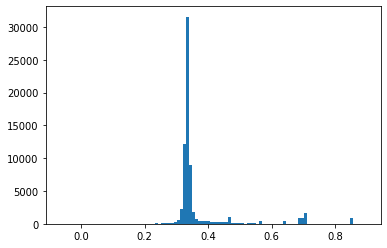

In [663]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [ ]:
y_competition  = []
modelnn.eval()

for i, embed in enumerate(x_competition_embed_with_ph):
    
    diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
    res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)
    print("Working on sequence {}... result is {}".format(i, np.median(res)))
    y_competition.append(np.median(res))

Working on sequence 0... result is 0.45111164450645447
Working on sequence 1... result is 0.455573171377182
Working on sequence 2... result is 0.45463258028030396
Working on sequence 3... result is 0.4517422020435333
Working on sequence 4... result is 0.4503691792488098
Working on sequence 5... result is 0.4566289484500885
Working on sequence 6... result is 0.4518430829048157
Working on sequence 7... result is 0.4524092376232147
Working on sequence 8... result is 0.4515807330608368
Working on sequence 9... result is 0.46228885650634766
Working on sequence 10... result is 0.45455223321914673
Working on sequence 11... result is 0.4514642357826233
Working on sequence 12... result is 0.4544565677642822
Working on sequence 13... result is 0.4535406231880188
Working on sequence 14... result is 0.45184090733528137
Working on sequence 15... result is 0.44834938645362854
Working on sequence 16... result is 0.4569673240184784
Working on sequence 17... result is 0.4444270730018616
Working on sequ

Working on sequence 148... result is 0.4562358856201172
Working on sequence 149... result is 0.4546849727630615
Working on sequence 150... result is 0.4520258903503418
Working on sequence 151... result is 0.45041733980178833
Working on sequence 152... result is 0.4601461589336395
Working on sequence 153... result is 0.4536442458629608
Working on sequence 154... result is 0.45519036054611206
Working on sequence 155... result is 0.4560788869857788
Working on sequence 156... result is 0.4432753324508667
Working on sequence 157... result is 0.4542824327945709
Working on sequence 158... result is 0.4321579039096832
Working on sequence 159... result is 0.4454224109649658
Working on sequence 160... result is 0.4426361620426178
Working on sequence 161... result is 0.4396879971027374
Working on sequence 162... result is 0.45730915665626526
Working on sequence 163... result is 0.456014484167099
Working on sequence 164... result is 0.4465819001197815
Working on sequence 165... result is 0.4534744

Working on sequence 294... result is 0.4607422649860382
Working on sequence 295... result is 0.45179811120033264
Working on sequence 296... result is 0.45339658856391907
Working on sequence 297... result is 0.45344865322113037
Working on sequence 298... result is 0.4555966854095459
Working on sequence 299... result is 0.45148766040802
Working on sequence 300... result is 0.4588221609592438
Working on sequence 301... result is 0.4496068060398102
Working on sequence 302... result is 0.44780564308166504
Working on sequence 303... result is 0.456119179725647
Working on sequence 304... result is 0.4487018585205078
Working on sequence 305... result is 0.45521414279937744
Working on sequence 306... result is 0.45587706565856934
Working on sequence 307... result is 0.45561471581459045
Working on sequence 308... result is 0.45552128553390503
Working on sequence 309... result is 0.446930468082428
Working on sequence 310... result is 0.45692458748817444
Working on sequence 311... result is 0.4478

Working on sequence 440... result is 0.4520134925842285
Working on sequence 441... result is 0.4496203660964966
Working on sequence 442... result is 0.4562337398529053
Working on sequence 443... result is 0.4515145421028137
Working on sequence 444... result is 0.45501160621643066
Working on sequence 445... result is 0.45229464769363403
Working on sequence 446... result is 0.4553245007991791
Working on sequence 447... result is 0.44743406772613525
Working on sequence 448... result is 0.44754892587661743
Working on sequence 449... result is 0.4535181224346161
Working on sequence 450... result is 0.4531102180480957
Working on sequence 451... result is 0.4538668990135193
Working on sequence 452... result is 0.4640347957611084
Working on sequence 453... result is 0.44314467906951904
Working on sequence 454... result is 0.4295039772987366
Working on sequence 455... result is 0.43479564785957336
Working on sequence 456... result is 0.441621333360672
Working on sequence 457... result is 0.4458

Working on sequence 586... result is 0.43858227133750916
Working on sequence 587... result is 0.4574089050292969
Working on sequence 588... result is 0.4417937099933624
Working on sequence 589... result is 0.4524136185646057
Working on sequence 590... result is 0.4526158571243286
Working on sequence 591... result is 0.44011589884757996
Working on sequence 592... result is 0.4514562487602234
Working on sequence 593... result is 0.44825053215026855
Working on sequence 594... result is 0.44868004322052
Working on sequence 595... result is 0.4481779932975769
Working on sequence 596... result is 0.44838088750839233
Working on sequence 597... result is 0.4518062174320221
Working on sequence 598... result is 0.4612864553928375
Working on sequence 599... result is 0.44152122735977173
Working on sequence 600... result is 0.45041969418525696
Working on sequence 601... result is 0.4500534236431122
Working on sequence 602... result is 0.4534003436565399
Working on sequence 603... result is 0.44818

Working on sequence 732... result is 0.4494363069534302
Working on sequence 733... result is 0.45193395018577576
Working on sequence 734... result is 0.4523923695087433
Working on sequence 735... result is 0.4497876465320587
Working on sequence 736... result is 0.45533767342567444
Working on sequence 737... result is 0.45741260051727295
Working on sequence 738... result is 0.44720059633255005
Working on sequence 739... result is 0.4533999562263489
Working on sequence 740... result is 0.45080429315567017
Working on sequence 741... result is 0.4580821692943573
Working on sequence 742... result is 0.4577343165874481
Working on sequence 743... result is 0.45507287979125977
Working on sequence 744... result is 0.45540621876716614
Working on sequence 745... result is 0.4503331184387207
Working on sequence 746... result is 0.4492682218551636
Working on sequence 747... result is 0.44974830746650696
Working on sequence 748... result is 0.4509812593460083
Working on sequence 749... result is 0.4

In [ ]:
plt.plot(y_competition)

In [ ]:
competition_tm = [100 * y for y in y_competition]

In [ ]:
submission = pd.read_csv("./proteindata/sample_submission.csv")

In [ ]:
submission

In [ ]:
competition_tm_round = [round(x, 1) for x in competition_tm]
competition_tm_round

In [ ]:
submission['tm'] = competition_tm_round

In [ ]:
filename_submission = "./proteindata/submission_0101_v1.csv"

In [ ]:
submission.to_csv(filename_submission, index = False)

In [ ]:
!kaggle competitions submit -c novozymes-enzyme-stability-prediction -f "./proteindata/submission_dualRegp12.csv" -m Stra_DualReg

In [ ]:
!kaggle competitions submissions -c novozymes-enzyme-stability-prediction 